In [4]:
!pip install git+https://github.com/openai/CLIP.git
import os
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-t0u_pl7f
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-t0u_pl7f
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [5]:
k=10
batch_size= 64
FINE_TUNE = False  # Set to False to skip training
TRAIN_LAST_LAYER_ONLY = False  # Set to False to fine-tune entire model
epochs = 2
lr = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# image_size = (224, 224)
# normalize_mean = [0.485, 0.456, 0.406]
# normalize_std = [0.229, 0.224, 0.225]

In [6]:
class ImageTextDataset(Dataset):
    def __init__(self, root_folder, transform):
        self.transform = transform
        self.img_paths = []
        self.labels = []
        # Walk through subfolders
        for label_name in os.listdir(root_folder):
            label_path = os.path.join(root_folder, label_name)
            if os.path.isdir(label_path):
                for img_file in os.listdir(label_path):
                    self.img_paths.append(os.path.join(label_path, img_file))
                    self.labels.append(label_name)  # folder name as label

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label, os.path.basename(self.img_paths[idx])


In [7]:
model, preprocess = clip.load("ViT-B/32", device=device)

if not FINE_TUNE:
    for param in model.parameters():
        param.requires_grad = False
elif TRAIN_LAST_LAYER_ONLY:
    for name, param in model.named_parameters():
        if "proj" in name or "visual.proj" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
else:
    for param in model.parameters():
        param.requires_grad = True


In [ ]:
def fine_tune_clip(train_loader, model, epochs=3, lr=1e-5):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for images, labels in train_loader:
            images = images.to(device)
            texts = clip.tokenize([class_names[i] for i in labels]).to(device)

            image_features = model.encode_image(images)
            text_features = model.encode_text(texts)

            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)

            logits_per_image = image_features @ text_features.t()
            logits_per_text = text_features @ image_features.t()
            ground_truth = torch.arange(len(images), device=device)

            loss = (loss_fn(logits_per_image, ground_truth) + loss_fn(logits_per_text, ground_truth)) / 2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f}")


In [18]:
def encode_images(image_folder, model, preprocess):
    image_paths = []
    for root, _, files in os.walk(image_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                image_paths.append(os.path.join(root, file))
    
    images = [preprocess(Image.open(p).convert("RGB")) for p in image_paths]
    images = torch.stack(images).to(device)

    with torch.no_grad():
        features = model.encode_image(images)
        features /= features.norm(dim=-1, keepdim=True)

    return features, image_paths


In [10]:
def retrieve(query_features, gallery_features, gallery_paths, k):
    similarities = query_features @ gallery_features.T  # cosine similarity matrix
    topk_values, topk_indices = similarities.topk(k, dim=-1)

    results = []
    for i in range(query_features.shape[0]):
        retrieved = [gallery_paths[idx] for idx in topk_indices[i].cpu().numpy()]
        results.append(retrieved)
    return results


In [1]:
def visualize_retrieval(query_paths, retrieval_results):
    for i, query_path in enumerate(query_paths):
        plt.figure(figsize=(15, 5))
        
        # Show query
        plt.subplot(1, k + 1, 1)
        plt.title (Image.open(query_path))
        plt.axis("off")
        plt.imshow(Image.open(query_path))
        
        # Show retrieved images
        for j, img_path in enumerate(retrieval_results[i]):
            plt.subplot(1, 6, j+2)
            plt.title(f"Rank {j+1}")
            plt.axis("off")
            plt.imshow(Image.open(img_path))
        plt.show()


In [12]:
def compute_accuracy(query_labels, retrieval_results, gallery_labels):
    correct = 0
    for i, retrieved_imgs in enumerate(retrieval_results):
        # Check if any retrieved image has the same label as query
        query_label = query_labels[i]
        retrieved_labels = [gallery_labels[os.path.basename(p)] for p in retrieved_imgs]
        if query_label in retrieved_labels:
            correct += 1
    return correct / len(query_labels)


ValueError: num must be an integer with 1 <= num <= 6, not 7

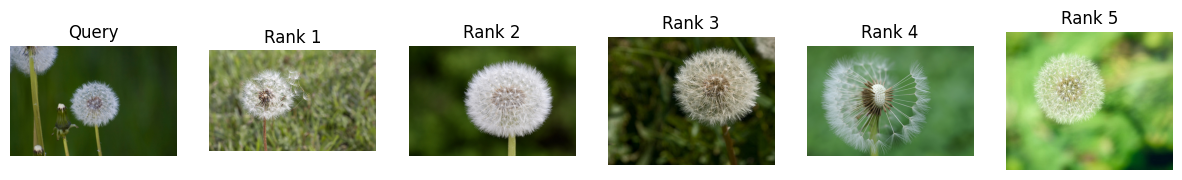

In [19]:
from torchvision.datasets import ImageFolder


BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = "/home/disi/ml-project-intro-1/data"
training_dir = os.path.join(DATA_DIR, "train")
val_dir = os.path.join(DATA_DIR, "val")
test_dir = os.path.join(DATA_DIR, "test")

# Load training data
train_dataset = ImageFolder(training_dir, transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Get class names for text labels
class_names = train_dataset.classes

# Optional fine-tuning
if FINE_TUNE:
    fine_tune_clip(train_loader, model, class_names)

# Encode gallery and query images
gallery_features, gallery_paths = encode_images(test_dir, model, preprocess)
query_features, query_paths = encode_images(val_dir, model, preprocess)

# Retrieve and visualize
retrieval_results = retrieve(query_features, gallery_features, gallery_paths, k=k)
visualize_retrieval(query_paths, retrieval_results)
